Código adaptado de:

[1] Aurélien Géron, Hands-On Machine Learning with Scikit-Learn: Concepts, Tools and Techniques to Build Intelligent Systems, Keras & tensorFlow, Third Edition, O'Reilly, 2023.

# Bibliotecas

In [41]:
%pip install -q -U gymnasium[classic_control]

zsh:1: no matches found: gymnasium[classic_control]
Note: you may need to restart the kernel to use updated packages.


In [42]:
import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import gymnasium as gym
import numpy as np
from tqdm.auto import tqdm
from collections import deque
import pandas as pd
import matplotlib.animation
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

# Hiperparâmetros

In [43]:
N_EPISODES = 600
MAX_STEPS = 200
BATCH_SIZE = 32
DISCOUNT_FACTOR = 0.95
LEARNING_RATE = 1e-2
ENVIRONMENT = "CartPole-v1"  # "CartPole-v1", "Acrobot-v1", "MountainCar-v0"

# Funções utilitárias

In [44]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ambiente

In [45]:
env = gym.make(ENVIRONMENT, render_mode="rgb_array")

# Política $\epsilon$-gulosa

In [46]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

# Replay buffer

In [47]:
replay_buffer = deque(maxlen=2000)

In [48]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

# Deep Q-Network ("básico")

## Modelo

In [49]:
tf.random.set_seed(42)

input_shape = env.observation_space.shape
n_outputs   = env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

## Treinamento

In [50]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [51]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = -np.inf

batch_size = BATCH_SIZE
discount_factor = DISCOUNT_FACTOR
optimizer = tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.MeanSquaredError()

replay_buffer = deque(maxlen=2000)  # resets the replay buffer

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = loss_fn(target_Q_values, Q_values)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [55]:
pbar = tqdm(range(N_EPISODES), desc="Eps", unit="ep")
for episode in pbar:
    obs, info = env.reset()
    total_reward = 0
    for step in range(MAX_STEPS):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        total_reward += reward
        if done or truncated:
            break

    pbar.set_description(f"Episode {episode+1}/{N_EPISODES}")
    pbar.set_postfix({
        "steps": step+1,
        "reward": f"{total_reward:.1f}",
        "eps":   f"{epsilon:.3f}"
    })
    pbar.update(0)

    rewards.append(total_reward)
    if total_reward >= best_score:
        best_weights = model.get_weights()
        best_score = total_reward

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode 6/600:   1%|          | 6/600 [00:00<00:06, 87.00ep/s, steps=21, reward=21.0, eps=0.990]


UnavailableError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code

  File "/tmp/ipykernel_108259/1577245578.py", line 7, in <module>

  File "/tmp/ipykernel_108259/1027865768.py", line 2, in play_one_step

  File "/tmp/ipykernel_108259/3552904983.py", line 5, in epsilon_greedy_policy

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 566, in predict

  File "/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 260, in one_step_on_data_distributed

No PTX compilation provider is available. Neither ptxas/nvlink nor nvjtlink is available. As a fallback you can enable JIT compilation in the CUDA driver via the flag `--xla_gpu_unsafe_fallback_to_driver_on_ptxas_not_found`. Details: 
 - Has NvJitLink support: LibNvJitLink is not supported (disabled during compilation).
 - Has NvPtxCompiler support: LibNvPtxCompiler is not supported (disabled during compilation).
 - Parallel compilation support is desired: 0
 - ptxas_path: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/bin/ptxas, /home/daniel/.elan/bin/ptxas, /home/daniel/.nvm/versions/node/v22.17.0/bin/ptxas, /home/daniel/.config/herd-lite/bin/ptxas, /home/daniel/develop/flutter/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /snap/bin/ptxas, /snap/bin/ptxas, /home/daniel/.local/share/JetBrains/Toolbox/scripts/ptxas, ipykernel_launcher.runfiles/cuda_nvcc/bin/ptxas, ipykern/cuda_nvcc/bin/ptxas, bin/ptxas, /usr/local/cuda/bin/ptxas, /opt/cuda/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/ptxas
 - ptxas_version: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/bin/ptxas, /home/daniel/.elan/bin/ptxas, /home/daniel/.nvm/versions/node/v22.17.0/bin/ptxas, /home/daniel/.config/herd-lite/bin/ptxas, /home/daniel/develop/flutter/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /snap/bin/ptxas, /snap/bin/ptxas, /home/daniel/.local/share/JetBrains/Toolbox/scripts/ptxas, ipykernel_launcher.runfiles/cuda_nvcc/bin/ptxas, ipykern/cuda_nvcc/bin/ptxas, bin/ptxas, /usr/local/cuda/bin/ptxas, /opt/cuda/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/ptxas, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/ptxas
 - nvlink_path: Couldn't find a suitable version of nvlink. The following locations were considered: ./cuda_sdk_lib/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/bin/nvlink, /home/daniel/.elan/bin/nvlink, /home/daniel/.nvm/versions/node/v22.17.0/bin/nvlink, /home/daniel/.config/herd-lite/bin/nvlink, /home/daniel/develop/flutter/bin/nvlink, /usr/local/sbin/nvlink, /usr/local/bin/nvlink, /usr/sbin/nvlink, /usr/bin/nvlink, /sbin/nvlink, /bin/nvlink, /usr/games/nvlink, /usr/local/games/nvlink, /snap/bin/nvlink, /snap/bin/nvlink, /home/daniel/.local/share/JetBrains/Toolbox/scripts/nvlink, ipykernel_launcher.runfiles/cuda_nvcc/bin/nvlink, ipykern/cuda_nvcc/bin/nvlink, bin/nvlink, /usr/local/cuda/bin/nvlink, /opt/cuda/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/nvlink
 - nvlink_version: Couldn't find a suitable version of nvlink. The following locations were considered: ./cuda_sdk_lib/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/bin/nvlink, /home/daniel/.elan/bin/nvlink, /home/daniel/.nvm/versions/node/v22.17.0/bin/nvlink, /home/daniel/.config/herd-lite/bin/nvlink, /home/daniel/develop/flutter/bin/nvlink, /usr/local/sbin/nvlink, /usr/local/bin/nvlink, /usr/sbin/nvlink, /usr/bin/nvlink, /sbin/nvlink, /bin/nvlink, /usr/games/nvlink, /usr/local/games/nvlink, /snap/bin/nvlink, /snap/bin/nvlink, /home/daniel/.local/share/JetBrains/Toolbox/scripts/nvlink, ipykernel_launcher.runfiles/cuda_nvcc/bin/nvlink, ipykern/cuda_nvcc/bin/nvlink, bin/nvlink, /usr/local/cuda/bin/nvlink, /opt/cuda/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/nvlink, /home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/nvlink
 - Driver compilation is enabled: 0

	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_870]

## Visualização dos resultados

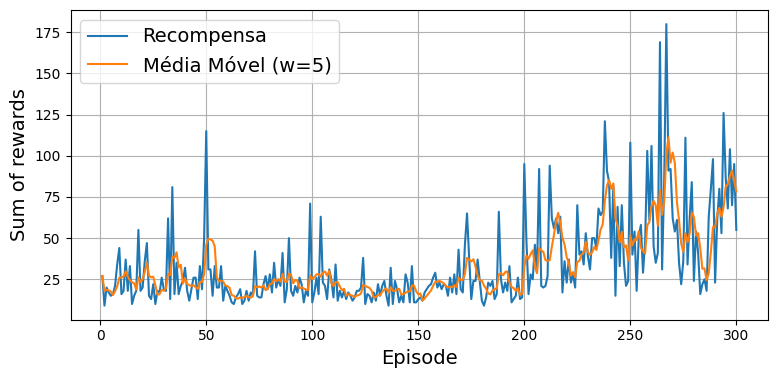

In [ ]:
episodes = np.arange(1, len(rewards) + 1)
df = pd.DataFrame({"Episode": episodes,"Reward": rewards})
df["Reward_MM"] = df["Reward"].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(8, 4))
plt.plot(df["Episode"], df["Reward"], label="Recompensa")
plt.plot(df["Episode"], df["Reward_MM"], label="Média Móvel (w=5)")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.legend()
plt.grid(True)
save_fig("dqn_basic_rewards_plot")
plt.show()

## Animação

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make(ENVIRONMENT, render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

In [ ]:
show_one_episode(epsilon_greedy_policy)

# Deep Q-Network (redes principal e alvo)

## Modelos

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
target = tf.keras.models.clone_model(model)   # clone the model's architecture
target.set_weights(model.get_weights())       # copy the weights
target.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

## Treinamento

In [ ]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = -np.inf

batch_size = BATCH_SIZE
discount_factor = DISCOUNT_FACTOR
optimizer = tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.MeanSquaredError()

replay_buffer = deque(maxlen=2000)  # resets the replay buffer

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    # ------------------------------------------------------------------------
    # Alteração: No DQN "básico" tínhamos utilizado "next_Q_values = model.predict(next_states, verbose=0)"
    next_Q_values = target.predict(next_states, verbose=0)
    # ------------------------------------------------------------------------
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = loss_fn(target_Q_values, Q_values)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
pbar = tqdm(range(N_EPISODES), desc="Eps", unit="ep")
for episode in pbar:
    obs, info = env.reset()
    total_reward = 0
    for step in range(MAX_STEPS):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        total_reward += reward
        if done or truncated:
            break

    pbar.set_description(f"Episode {episode+1}/{N_EPISODES}")
    pbar.set_postfix({
        "steps": step+1,
        "reward": f"{total_reward:.1f}",
        "eps":   f"{epsilon:.3f}"
    })
    pbar.update(0)

    rewards.append(total_reward)
    if total_reward >= best_score:
        best_weights = model.get_weights()
        best_score = total_reward

    if episode > 50:
        training_step(batch_size)
        # ------------------------------------------------------------------------
        # Alteração
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
        # ------------------------------------------------------------------------

model.set_weights(best_weights)  # extra code – restores the best model weights

Eps:   0%|          | 0/300 [00:00<?, ?ep/s]

## Visualização dos resultados

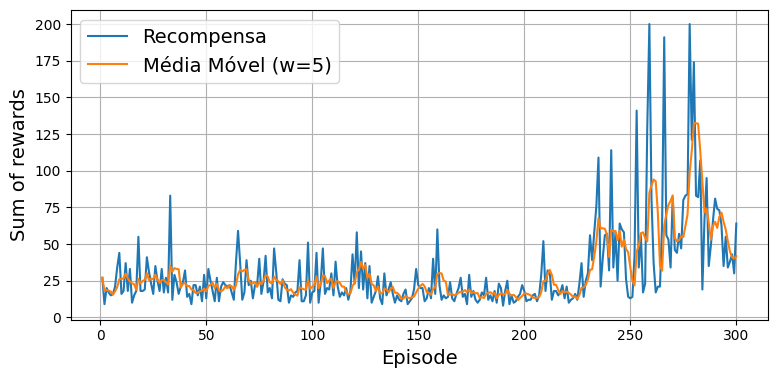

In [ ]:
episodes = np.arange(1, len(rewards) + 1)
df = pd.DataFrame({"Episode": episodes,"Reward": rewards})
df["Reward_MM"] = df["Reward"].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(8, 4))
plt.plot(df["Episode"], df["Reward"], label="Recompensa")
plt.plot(df["Episode"], df["Reward_MM"], label="Média Móvel (w=5)")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.legend()
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

## Animação

In [ ]:
def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make(ENVIRONMENT, render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(epsilon_greedy_policy)

# Double DQN

## Modelos

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())     # copy the weights

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Treinamento

In [ ]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = BATCH_SIZE
discount_factor = DISCOUNT_FACTOR
optimizer = tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.MeanSquaredError()

replay_buffer = deque(maxlen=2000)

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    # ------------------------------------------------------------------
    # DQN Básico
    # next_Q_values = model.predict(next_states, verbose=0)
    # max_next_Q_values = next_Q_values.max(axis=1)
    # ------------------------------------------------------------------
    # DQN + (rede principal + rede alvo)
    # next_Q_values = target.predict(next_states, verbose=0)
    # max_next_Q_values = next_Q_values.max(axis=1)
    # ------------------------------------------------------------------
    #################### CHANGED SECTION ####################
    # Double DQN
    next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask).sum(axis=1)
    #########################################################

    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = loss_fn(target_Q_values, Q_values)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
pbar = tqdm(range(N_EPISODES), desc="Eps", unit="ep")
for episode in pbar:
    obs, info = env.reset()
    total_reward = 0
    for step in range(MAX_STEPS):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        total_reward += reward
        if done or truncated:
            break

    pbar.set_description(f"Episode {episode+1}/{N_EPISODES}")
    pbar.set_postfix({
        "steps": step+1,
        "reward": f"{total_reward:.1f}",
        "eps":   f"{epsilon:.3f}"
    })
    pbar.update(0)

    rewards.append(total_reward)
    if total_reward >= best_score:
        best_weights = model.get_weights()
        best_score = total_reward

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Eps:   0%|          | 0/300 [00:00<?, ?ep/s]

## Visualização dos resultados

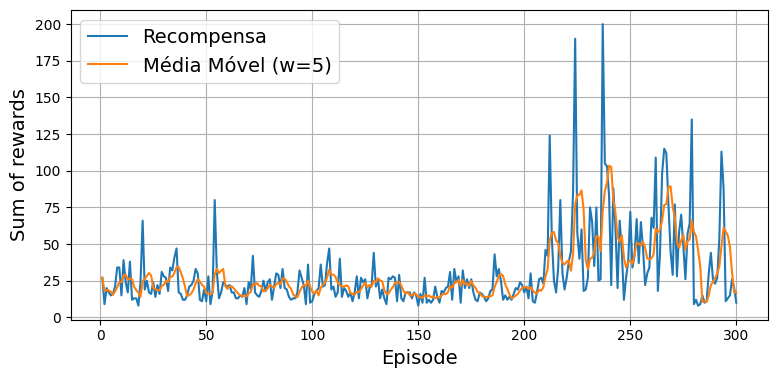

In [ ]:
episodes = np.arange(1, len(rewards) + 1)
df = pd.DataFrame({"Episode": episodes,"Reward": rewards})
df["Reward_MM"] = df["Reward"].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(8, 4))
plt.plot(df["Episode"], df["Reward"], label="Recompensa")
plt.plot(df["Episode"], df["Reward_MM"], label="Média Móvel (w=5)")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.legend()
plt.grid(True)
save_fig("double_dqn_basic_rewards_plot")
plt.show()

In [ ]:
show_one_episode(epsilon_greedy_policy)

## Animação

In [ ]:
def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make(ENVIRONMENT, render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(epsilon_greedy_policy)

In [ ]:
env.close()

# Tarefa

Compare o DQN (rede principal e alvo) e Double DQN nos os seguintes ambientes do [Classic Control](https://gymnasium.farama.org/environments/classic_control/) (fazendo as devidas modificações no código do experimento onde necessário):

 - [Acrobot](https://gymnasium.farama.org/environments/classic_control/acrobot/)

- [Mountain Car](https://gymnasium.farama.org/environments/classic_control/acrobot/)

Para cada ambiente mostre o gráfico do retorno por episódios, indique qual método obteve os melhores resultados e liste os hiperparâmetros utilizados (a arquitetura da rede neural também pode ser modificada).  